# 中介分析基本框架

假定\\(Y\\)是因变量，\\(X\\)是自变量，\\(M\\)是中介变量；其中，\\(X\\)部分（或完全）通过影响\\(M\\)而影响\\(Y\\)。这一关系可以表述为：

$$Y = \alpha_y + \beta_{yx} X + \epsilon_y$$

$$M = \alpha_m + \beta_{mx} X + \epsilon_m$$

$$Y = \alpha + \beta_{m} M + \beta_{x} X + \epsilon$$

如果我们将第二个公式代入到第三个公式，然后与第一个公式进行比较可以发现：

$$ \beta_{mx}\beta_m = \beta_{yx} - \beta_x$$

因此，只要我们估计第一个和第三个模型就可以得到中介效应 $\beta_{mx}\beta_m$。然而，为了估计中介效应是否显著，我们还需要估计相应的标准误$\widehat{\sigma_{\beta_{mx}\beta_m}}$。其中一种估计方法（Sobel，1982）如下：

$$\widehat{\sigma_{\beta_{mx}\beta_m}} = \sqrt{\widehat{\beta_{mx}^2} \widehat{\sigma^2_{\beta_{m}}}+\widehat{\beta_{m}^2} \widehat{\sigma^2_{\beta_{mx}}} }$$

可见，为了估计中介效应的标准误，需要同时估计第二和第三个模型。

得到标准误后，可以使用正态分布来估计其置信区间。然而，值得注意的是，由于中介效应呈偏态分布，根据上述标准误计算的置信区间无法很好反映真实的区间。

In [2]:
data(Prestige, package="car")
names(Prestige)

[1] "education" "income"    "women"     "prestige"  "census"    "type"

#### 例子:教育程度在多大程度上通过收入而影响职业声望？

通过拟合三个模型，我们可以通过两种不同的方法计算中介效应。

In [3]:
mod_y <- lm(prestige ~ education, data = Prestige)
mod_m <- lm(income ~ education, data = Prestige)
mod_full <- lm(prestige ~ income + education, data = Prestige)
coef(mod_m)['education'] * coef(mod_full)['income'] ## mediation effect by multiplication
med_eff <- coef(mod_y)['education'] - coef(mod_full)['education'] ## mediation effect by subtraction
med_eff ## save for futher use

education 
 1.223433

education 
 1.223433

下面我们直接计算中介效应的标准误，以及对95%置信的估计。

In [4]:
sd_eff_sq <- coef(mod_m)['education']^2 * vcov(mod_full)['income', 'income'] + 
             coef(mod_full)['income']^2 * vcov(mod_m)['education', 'education']
sd_eff <- sqrt(sd_eff_sq) ## SE of mediation effect
c(med_eff - 1.96*sd_eff, med_eff + 1.96*sd_eff) # 95% CI

education education 
0.7029722 1.7438945

我们可以把上面的计算过程封装起来，从而得到计算中介效应及其区间的函数。

## 通过bootstrap法计算中介效应及其置信区间


Bollen和Stine是这个方法的倡导者。相关讨论详见：Bollen, K. A. & Stine, R. 1990. Direct and indirect effects: classical and bootstrap estimates of variability Sociological Methodology, 20, 115–140.

首先，定义一个函数计算中介效应。该函数具有两个参数，第一个参数是数据框，第二个参数是bootstrap法随机抽取的案例的标识（行数）。

In [5]:
coef_diff <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education'] ## mediation effect by subtraction
    med_eff
}

接下来，加载boot程序包，并调用同名函数进行bootstrap计算。其中，我们将抽样次数R设置为1000，stype参数设置为i。

In [6]:
library(boot)
(med.boot <- boot(Prestige, coef_diff, R = 1000, stype="i"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff, R = 1000, stype = "i")


Bootstrap Statistics :
    original     bias    std. error
t1* 1.223433 0.03451726    0.261108

original: 原始样本计算得到的统计量
bias: R次bootstrap得到样本量的均值 - original
std.error: R次bootstrap样本统计量的标准差

第三，调用boot.ci函数计算置信区间。与Bollen and Stine（1990）相一致，我们计算的是percentile置信区间（type = "perc"）。

In [7]:
boot.ci(med.boot, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.776,  1.829 )  
Calculations and Intervals on Original Scale

通过密度图来检查bootstrap结果的分布。同时，通过curve函数增加一个正态分布曲线来做参考。结果显示，bootstrap结果略显偏态分布。

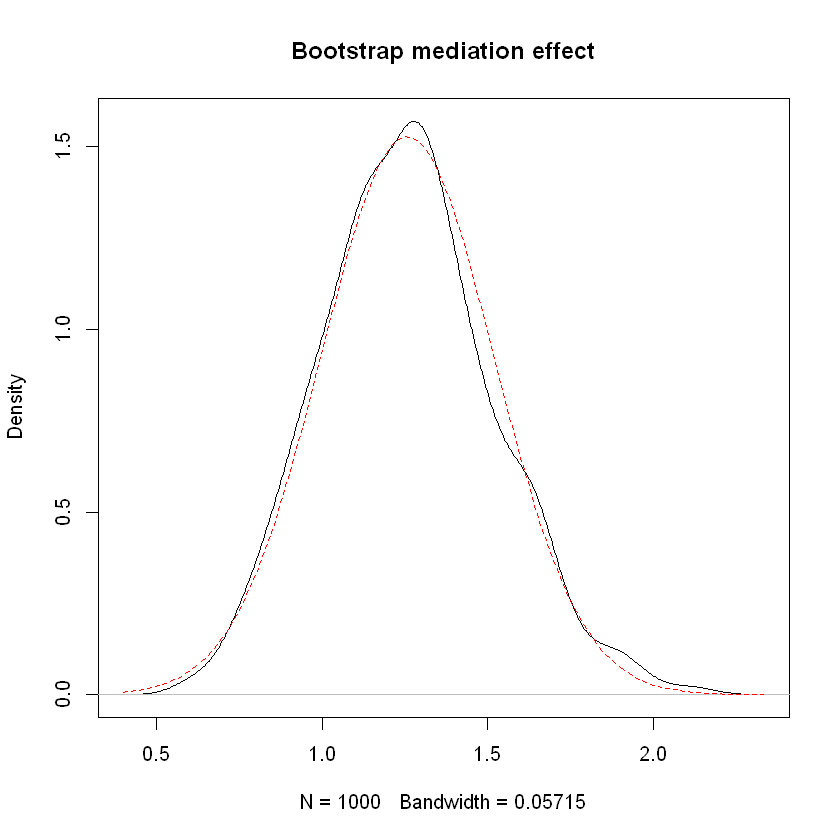

In [8]:
plot(density(med.boot$t), main = "Bootstrap mediation effect")
curve(dnorm(x, mean=mean(med.boot$t), sd=sd(med.boot$t)), add = TRUE, col='red', lty=2)

In [12]:
coef_diff2 <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education'] ## mediation effect by subtraction
    pct <- med_eff / coef(mod_y)['education']
    c(med_eff, pct)
}

(med.boot2 <- boot(Prestige, coef_diff2, R = 1000, stype="i"))
boot.ci(med.boot2, 1, type="perc")
boot.ci(med.boot2, 2, type="perc")


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff2, R = 1000, stype = "i")


Bootstrap Statistics :
     original      bias    std. error
t1* 1.2234333 0.022060558  0.25993042
t2* 0.2282151 0.004306117  0.04935087

Warning message:
In norm.inter(t, alpha): extreme order statistics used as endpoints

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot2, conf = 1, type = "perc")

Intervals : 
Level     Percentile     
100%   (  0.597,      NA )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable

Warning message:
In norm.inter(t, alpha): extreme order statistics used as endpointsWarning message:
In qnorm(alpha[temp]): NaNs producedWarning message:
In qnorm(k[temp]/(R + 1)): NaNs producedWarning message:
In qnorm((k[temp] + 1)/(R + 1)): NaNs produced

ERROR: Error in tstar[k[temp]]: only 0's may be mixed with negative subscripts


## 贝叶斯中介分析：单层次回归

通过贝叶斯方法计算上述中介分析可以得到中介效应的分布，从而可以直接计算中介效应的置信区间，而无需依赖对中介效应抽样分布的假定（详见Yuan and MacKinnon. (2009). Bayesian Mediation Analysis. Psychol Methods. 14(4): 301–322. ）。我们可以使用rjags程序包进行计算。

首先，我们使用BUGS/JAGS语言编写上述模型，并将模型以一个字符对象的形式保存起来。在下面的模型设定中：
* N表示样本量
* 在BUGS语言中，~ 表示分布，<- 则表示确定性关系
* 在BUGS语言中， dnorm(正态分布)的第二个参数是precision，是方差的倒数
* 在BUGS语言中，dgamma表示gamma分布，该分布描述方差先验分布，a和b这两个参数设置为0.001 意味着无信息先验分布
* 通过定义theta =  beta_mx * beta_m，我们可以得到中介效应

In [22]:
mediation_model <- "
model {
   for(i in 1:N)
   {
      m[i] ~ dnorm(mean.m[i], prec.m)
      mean.m[i] <- alpha_m + beta_mx * x[i]
      y[i] ~ dnorm(mean.y[i], prec.y)
      mean.y[i] <- alpha + beta_m * m[i] + beta_x * x[i]
   }
   alpha_m ~ dnorm(0, 1.0E-6)
   beta_mx ~ dnorm(0, 1.0E-6)
   alpha ~ dnorm(0, 1.0E-6)
   beta_m ~ dnorm(0, 1.0E-6)
   beta_x ~ dnorm(0, 1.0E-6)
   # dgamma (a, b) is a gamma distribution with the shape parameter a and
   # inverse scale parameter b.
   prec.y ~ dgamma(0.001, 0.001)
   prec.m ~ dgamma(0.001, 0.001)
   theta <-  beta_mx * beta_m
}
"

第二，将所需要的数据构建成一个列表。

第三，加载rjags程序包，调用jags.model生成一个BUGS模型。值得注意的是，jags.model的第一个参数是文本连接（或保存在电脑中的文本文件），因此我们需要通过textConnect函数将上述字符格式的BUGS模型定义转换为文本连接。

第四，通过update函数，开始更新模型。

第五，通过coda.samples函数抽样，得到我们所需要的信息（在这里例子中，我们关心的是theta）。

最后，通过summary函数和plot函数得到theta的分布。

In [23]:
DL <- list(N = nrow(Prestige),
           y = Prestige$prestige,
           x = Prestige$education,
           m = Prestige$income
          )

library(rjags)
jags <- jags.model(textConnection(mediation_model), data=DL,n.chains=4, n.adapt=100)
update(jags, 5000)
samps <- coda.samples(jags, c("theta"), 2000)
summary(samps)
# plot(samps)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 204
   Unobserved stochastic nodes: 7
   Total graph size: 818

Initializing model




Iterations = 5001:7000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      1.009088       0.202368       0.002263       0.007522 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6264 0.8712 1.0019 1.1386 1.4208 


从上述图形可知，模型混合得良好（可以进一步通过诊断分析来判断模型是否混合良好），得到的分布可认为接近理论分布。
* 分析结果现实，中介效应的分别略呈右偏态。
* 比较贝叶斯中介分析和Sobel方法的结果可知，Sobel方法略高估了中介效应。

## 贝叶斯中介分析：多层次回归（模拟分析）

贝叶斯中介分析可以容易地延伸至多层次回归的中介分析。对于如下模型：
$$M_{ij} = \alpha_{m,j} + \beta_{mx,j} X_{ij} + \epsilon_{m,ij}$$

$$Y_{ij} = \alpha_j + \beta_{m,j} M_{ij} + \beta_{x,j} X_{ij} + \epsilon_{ij}$$

我们设定上述模型的参数分布，从而可以生成模拟数据集。其中，

$$\alpha_{m,j} \sim\ N(0, 0.6)$$
$$\alpha_{j} \sim\ N(0, 0.4)$$
$$\epsilon_{m,ij} \sim\ N(0, 0.65)$$
$$\beta_{x,j} \sim\ N(0.2, 0.04)$$
$$\epsilon_{ij} \sim\ N(0, 0.45)$$

系数$(\beta_{mx, j}, \beta_{m,j})$对应的期望为$(0.6, 0.6)$，方差分别是$(0.3, 0.4)$，协方差矩阵为0.13。

此外，第一层次有N1=50单位，第二层次有N2=30单位。

下面的命令生成符合上述设定的随机数：

In [4]:
I <- 50 ## the i-th measure for a specific subject
J <- 30 ## the j-th subject
N <- I * J
Xij <- rnorm(n = N, mean = 30, sd = 5)
measures <- rep(1:I, times = J)
subjects <- rep(1:J, each=I)
alpha_mj <- rep( rnorm(J, 0, sqrt(0.6)), each=I)
alpha_j <- rep( rnorm(J, 0, sqrt(0.4)), each=I)
e_mij <- rnorm(N, 0, sqrt(0.65))
beta_xj <- rep( rnorm(J, 0.2, sqrt(0.04)), each=I)
e_ij <- rnorm(N, 0, sqrt(0.45))
library(MASS)
Beta_mxj_Beta_mj <- mvrnorm(n=J, mu=c(0.4, 0.5), Sigma=matrix(c(0.3,0.13,0.13,0.4), ncol=2))
beta_mxj <- rep( Beta_mxj_Beta_mj[,1], each=I)
beta_mj <- rep( Beta_mxj_Beta_mj[,2], each=I)
Mij <- alpha_mj + beta_mxj * Xij + e_mij
Yij <- alpha_j + beta_mj * Mij + beta_xj * Xij + e_ij

接下来，通过BUGS（JAGS）语言拟合上述模型。

In [1]:
med_mlm <- "
model {
  
  ## random coefficients
  for (j in 1:J) {
    # indepdent normal distribution
    alpha_mj[j] ~ dnorm(alpha_mj_mu, prec.alpha_mj_mu)
    alpha_j[j] ~ dnorm(alpha_j_mu, prec.alpha_j_mu)
    beta_xj[j] ~ dnorm(beta_xj_mu, prec.beta_xj_mu)
    # bivariate normal distribution for beta_mxj and beta_mj
    Betas[j, 1:2] ~ dmnorm(Betas_mu[ ], prec.Betas_mu[ , ])
    # note it is dmnorm instead of dnorm 
  }
  
  ## the two models
  for (irow in 1:N) {
    # model of m
    mean.m[irow] <- alpha_mj[ subjects[irow] ]  +  Betas[ subjects[irow] , 1] * x[irow]
    m[irow] ~ dnorm(mean.m[irow], prec.m)
    
    # model of y
    mean.y[irow] <-  alpha_j[ subjects[irow] ] + Betas[ subjects[irow] , 2] * m[irow] + beta_xj[ subjects[irow] ] * x[irow]
    y[irow] ~ dnorm(mean.y[irow], prec.y)
  }
  
  ## priors associated with indepdent random coefficients
  alpha_mj_mu ~ dnorm(0.0, 1.0E-6)
  alpha_j_mu ~ dnorm(0.0, 1.0E-6)
  beta_xj_mu ~ dnorm(0.000001, 1.0E-6) ## use a very small value instead of 0 to monitor ratio
  sigma.alpha_mj_mu ~ dunif(0, 100) ## note: it is dunif instead of runif
  sigma.alpha_j_mu ~ dunif(0, 100)
  sigma.beta_xj_mu ~ dunif(0, 100)
  prec.alpha_mj_mu <- pow(sigma.alpha_mj_mu, -2)
  prec.alpha_j_mu <- pow(sigma.alpha_j_mu, -2)
  prec.beta_xj_mu <- pow(sigma.beta_xj_mu, -2)
  ## alternatively, we can put priors on prec and then calc sigma
  
  ## priors on Betas_mu and prec.Betas_mu
  ## priors on Betas_mu
  Betas_mu[1:2] ~ dmnorm(mean[ ] , prec[,])
  ## specify the values of hypyer-priors
  mean[1] <- 0
  mean[2] <-  0
  prec[1, 1] <-  1.0E-6
  prec[1, 2] <-  0
  prec[2, 1] <-  0
  prec[2, 2] <-  1.0E-6
  ## priors on prec.Betas_mu (vague inverse-Wishart prior)
  prec.Betas_mu[1:2 , 1:2] ~ dwish(Omega[ , ], 2)
  Omega[1, 1] <-  0.001
  Omega[1, 2] <-  0.0
  Omega[2, 1] <-  0.0
  Omega[2, 2] <-  0.001
  
  # Priors for error term pricisions (inverse gamma priors)
  prec.m ~ dgamma(0.001, 0.001)
  prec.y ~ dgamma(0.001, 0.001)
  
  # vague uniform priors for standard deviations of the second level model
  sigma.beta2 ~ dunif(0, 100)
  sigma.taup ~ dunif(0, 100)
  sigma.beta3 ~ dunif(0, 100)
  prec.beta2 <-  1/(sigma.beta2*sigma.beta2)
  prec.taup <-  1/(sigma.taup*sigma.taup)
  prec.beta3 <-  1/(sigma.beta3*sigma.beta3)
  
  ## generated quantities
  var.Betas[1, 1] <-  prec.Betas_mu[2,2] / (prec.Betas_mu[1,1] * prec.Betas_mu[2,2] - prec.Betas_mu[1,2] * prec.Betas_mu[2,1])
  var.Betas[1, 2] <-  - prec.Betas_mu[1,2] / (prec.Betas_mu[1,1] * prec.Betas_mu[2,2] - prec.Betas_mu[1,2] * prec.Betas_mu[2,1])
  var.Betas[2, 1] <-  - prec.Betas_mu[2,1] / (prec.Betas_mu[1,1] * prec.Betas_mu[2,2] - prec.Betas_mu[1,2] * prec.Betas_mu[2,1])
  var.Betas[2, 2] <-  prec.Betas_mu[1,1] / (prec.Betas_mu[1,1] * prec.Betas_mu[2,2] - prec.Betas_mu[1,2] * prec.Betas_mu[2,1])
  
  ##  mediated is the average mediated effect
  mediated <- Betas_mu[1] * Betas_mu[2] + var.Betas[1, 2]
  total <-  Betas_mu[1] * Betas_mu[2] + var.Betas[1, 2] + beta_xj_mu
  ratio <-  mediated / total
}
"

In [5]:
library(rjags) 
mod <- jags.model(textConnection(med_mlm), data=list(N=N, J=J, y = Yij, x=Xij, m=Mij, subjects=subjects) )
update(mod, 10000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 13743

Initializing model



In [9]:
samp <- coda.samples(mod, variable.names = c("mediated", "total", "ratio", "alpha_j_mu","alpha_mj_mu", "Betas_mu", "beta_xj_mu"), n.iter = 5000)
summary(samp)


Iterations = 26001:31000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
Betas_mu[1]  0.4961 0.09333 0.0013199       0.001320
Betas_mu[2]  0.7045 0.10081 0.0014256       0.002793
alpha_j_mu  -0.1828 0.12593 0.0017809       0.015293
alpha_mj_mu -0.1095 0.20111 0.0028442       0.014231
beta_xj_mu   0.2080 0.04194 0.0005932       0.004014
mediated     0.4138 0.10747 0.0015198       0.002289
ratio        0.6584 0.07737 0.0010941       0.005490
total        0.6219 0.11273 0.0015943       0.001594

2. Quantiles for each variable:

               2.5%     25%     50%      75%   97.5%
Betas_mu[1]  0.3131  0.4365  0.4952  0.55702 0.67737
Betas_mu[2]  0.5055  0.6388  0.7032  0.77115 0.90598
alpha_j_mu  -0.4388 -0.2630 -0.1826 -0.10661 0.08254
alpha_mj_mu -0.5085 -0.2433 -0.1062  0.02444 0.27907
beta_xj_mu   0.1261  0.18